In [1]:
import datetime as dt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
idx = pd.IndexSlice

https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [3]:
filename_path = '_input/01_ecdc/COVID-19-geographic-disbtribution-worldwide-2020-03-13.xls'

In [4]:
# Goal is to compute cumulative sum and grow_rate

In [5]:
df = pd.read_excel(filename_path, index_col='DateRep', parse_dates=True)
df.rename_axis('Date', inplace=True)
df.head()

,CountryExp,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
Date,,,,,,
2020-03-11,Afghanistan,3,0,AF,NaN,Non-EU/EEA
2020-03-08,Afghanistan,3,0,AF,NaN,Non-EU/EEA
2020-03-02,Afghanistan,0,0,AF,NaN,Non-EU/EEA
2020-03-01,Afghanistan,0,0,AF,NaN,Non-EU/EEA
2020-02-29,Afghanistan,0,0,AF,NaN,Non-EU/EEA


In [6]:
df.tail()

,CountryExp,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
Date,,,,,,
2020-01-04,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-01-03,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-01-02,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-01-01,Vietnam,0,0,VN,NaN,Non-EU/EEA
2019-12-31,Vietnam,0,0,VN,NaN,Non-EU/EEA


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4905 entries, 2020-03-11 to 2019-12-31
Data columns (total 6 columns):
CountryExp      4905 non-null object
NewConfCases    4905 non-null int64
NewDeaths       4905 non-null int64
GeoId           4905 non-null object
Gaul1Nuts1      485 non-null object
EU              4905 non-null object
dtypes: int64(2), object(4)
memory usage: 268.2+ KB


In [8]:
df.describe()

,NewConfCases,NewDeaths
count,4905.000000,4905.000000
mean,27.290520,1.012640
std,295.060626,9.793038
min,-27.000000,-2.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,15141.000000,254.000000


In [9]:
df[['NewConfCases']].sum()

NewConfCases    133860
dtype: int64

In [10]:
df['CountryExp'].value_counts()

Netherlands                         74
Iran                                74
China                               74
South Korea                         74
Italy                               74
                                    ..
Honduras                             1
Ghana                                1
Bangladesh                           1
Holy See                             1
Democratic Republic of the Congo     1
Name: CountryExp, Length: 120, dtype: int64

In [11]:
countries_lst = list(df['CountryExp'].unique())

In [12]:
country_df = df.groupby(['CountryExp', 'Date']).sum()
country_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31             0          0
            2020-01-01             0          0
            2020-01-02             0          0
            2020-01-03             0          0
            2020-01-04             0          0
...                              ...        ...
Vietnam     2020-03-09             9          0
            2020-03-10             1          0
            2020-03-11             4          0
            2020-03-12             4          0
            2020-03-13             5          0

[4905 rows x 2 columns]

In [13]:
def growth_ratio(a, b):
    '''
    return growth ratio, it check denominator is larger than zero
    param: Value Today, Value Yesterday
    return: growth ratio
    '''
    if b > 0:
        return a/b
    else:
        return np.nan

In [14]:
pd.concat([country_df, country_df.shift(1)], axis=1).to_csv('temp.csv')

In [15]:
# I shift by 1 in order to align today data with yesterday data
# I need to unstack the country index before shifting
shift1_df = country_df.unstack(level=0).shift(1).stack(level=1).swaplevel(axis=0).sort_index()

In [16]:
grow_rate_new = pd.concat([country_df, shift1_df], axis=1).apply(lambda X: growth_ratio(X[0],X[2]), axis=1)
grow_rate_death = pd.concat([country_df, shift1_df], axis=1).apply(lambda X: growth_ratio(X[1],X[3]), axis=1)

In [17]:
grow_rate_new.rename('NewConfCases', inplace=True)
grow_rate_death.rename('NewDeaths', inplace=True)

CountryExp   Date      
Afghanistan  2019-12-31   NaN
             2020-01-01   NaN
             2020-01-02   NaN
             2020-01-03   NaN
             2020-01-04   NaN
                           ..
Vietnam      2020-03-09   NaN
             2020-03-10   NaN
             2020-03-11   NaN
             2020-03-12   NaN
             2020-03-13   NaN
Name: NewDeaths, Length: 5063, dtype: float64

In [18]:
growth_rate_df = pd.concat([grow_rate_new, grow_rate_death], axis=1)
growth_rate_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31           NaN        NaN
            2020-01-01           NaN        NaN
            2020-01-02           NaN        NaN
            2020-01-03           NaN        NaN
            2020-01-04           NaN        NaN
...                              ...        ...
Vietnam     2020-03-09      2.250000        NaN
            2020-03-10      0.111111        NaN
            2020-03-11      4.000000        NaN
            2020-03-12      1.000000        NaN
            2020-03-13      1.250000        NaN

[5063 rows x 2 columns]

In [19]:
growth_rate_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31           NaN        NaN
            2020-01-01           NaN        NaN
            2020-01-02           NaN        NaN
            2020-01-03           NaN        NaN
            2020-01-04           NaN        NaN
...                              ...        ...
Vietnam     2020-03-09      2.250000        NaN
            2020-03-10      0.111111        NaN
            2020-03-11      4.000000        NaN
            2020-03-12      1.000000        NaN
            2020-03-13      1.250000        NaN

[5063 rows x 2 columns]

In [20]:
#in order to perform cumsum within the country I need to unstack first
cumsum_df = country_df.unstack(level=0).cumsum().stack(level=1).swaplevel(axis=0).sort_index()
cumsum_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31           0.0        0.0
            2020-01-01           0.0        0.0
            2020-01-02           0.0        0.0
            2020-01-03           0.0        0.0
            2020-01-04           0.0        0.0
...                              ...        ...
Vietnam     2020-03-09          30.0        0.0
            2020-03-10          31.0        0.0
            2020-03-11          35.0        0.0
            2020-03-12          39.0        0.0
            2020-03-13          44.0        0.0

[4905 rows x 2 columns]

In [21]:
df = pd.concat({'cumsum' : cumsum_df, 
                'difference' : country_df,
                'growth_rate' : growth_rate_df},axis=1)

In [22]:
ch_df = df.loc['Switzerland', idx[:,'NewConfCases']]

In [23]:
def plot_country(df=df, country='Switzerland'):
    
    fig, ax = plt.subplots(3,2, figsize=(10,8))
    c_df = df.loc[country, idx[:,'NewConfCases']]
    
    date_first_case = (c_df.sum(axis=1)!=0).idxmax()
    date_first_case_str = date_first_case.strftime("%Y-%m-%d")
    print(date_first_case_str)
    
    for ith, clm in enumerate(c_df.columns):
        #c_df[c_df.sum(axis=1)!=0][[clm]].plot(ax=ax[ith,0])
        c_df[date_first_case:][[clm]].plot(ax=ax[ith,0])

    c_df = df.loc[country, idx[:,'NewDeaths']]
    for ith, clm in enumerate(c_df.columns):
        #c_df[c_df.sum(axis=1)!=0][[clm]].plot(ax=ax[ith,1])
        c_df[date_first_case:][[clm]].plot(ax=ax[ith,1])

    plt.tight_layout()  


2020-02-26
Switzerland


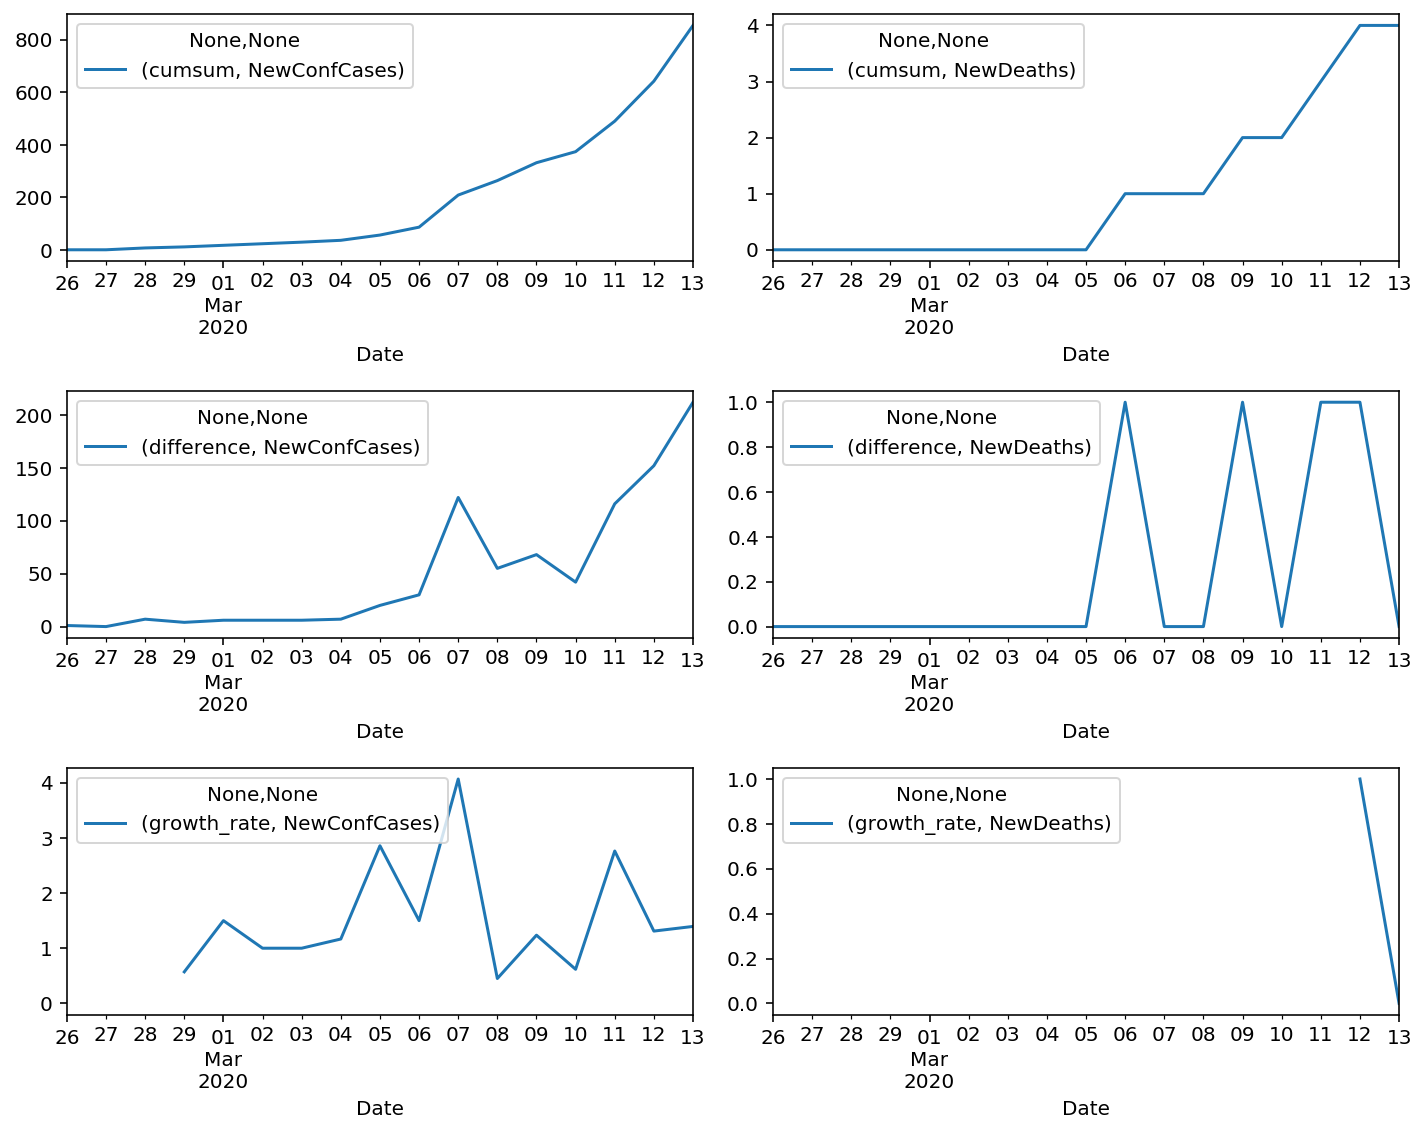

2020-01-31
Italy


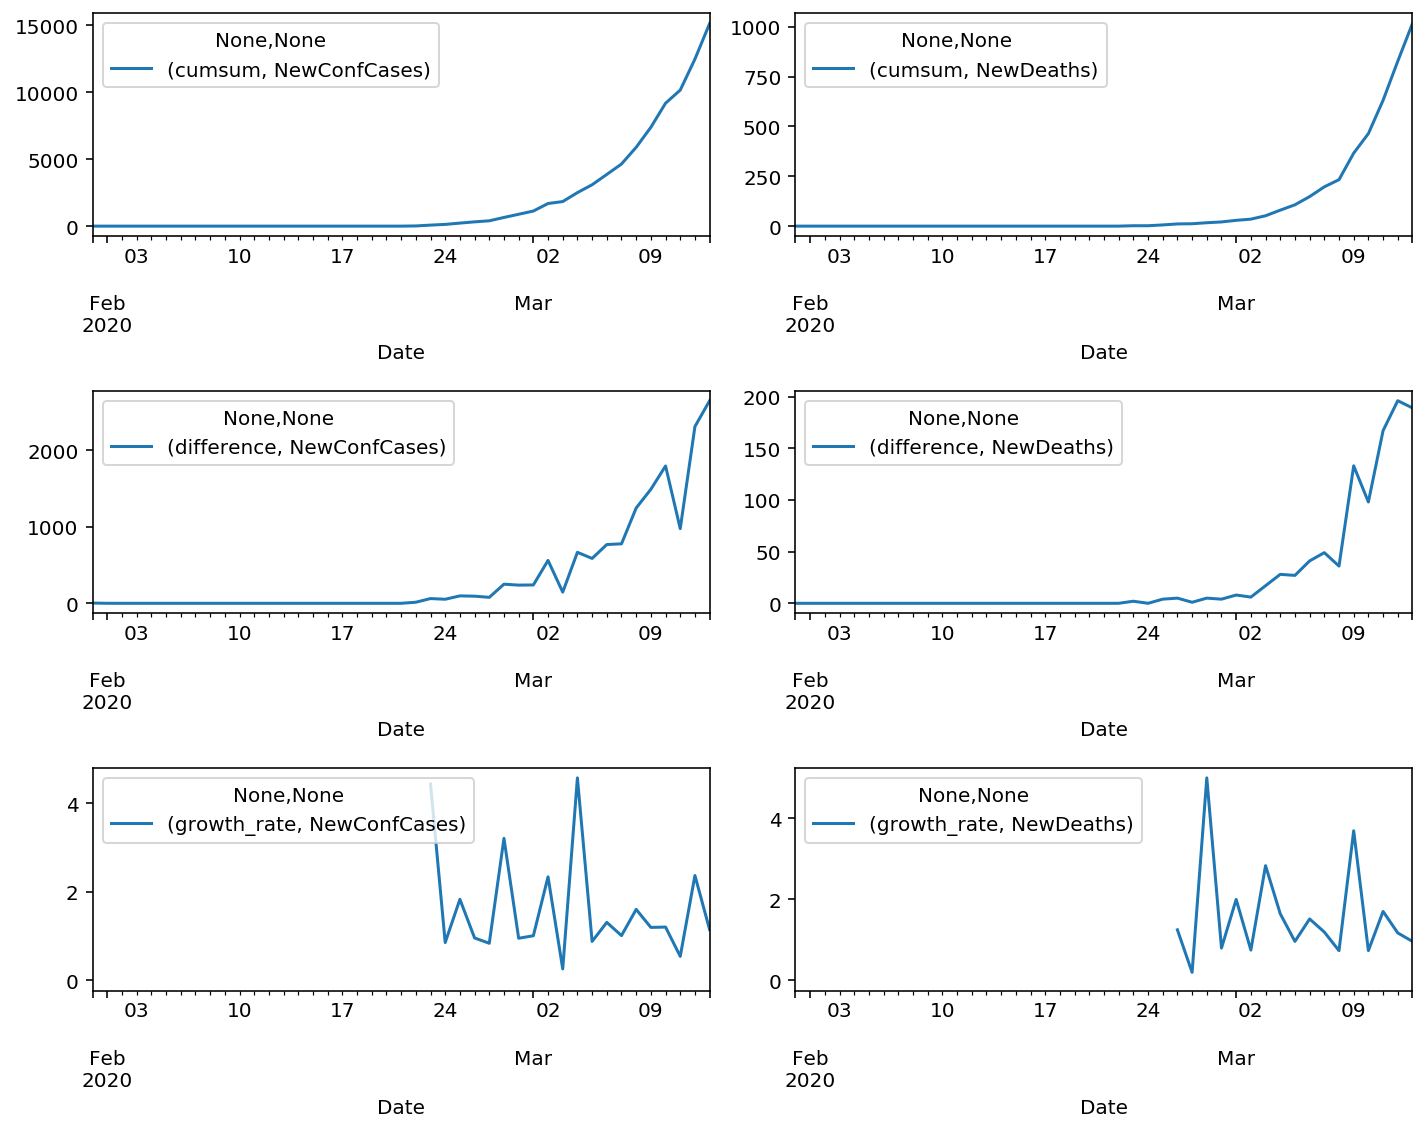

2019-12-31
China


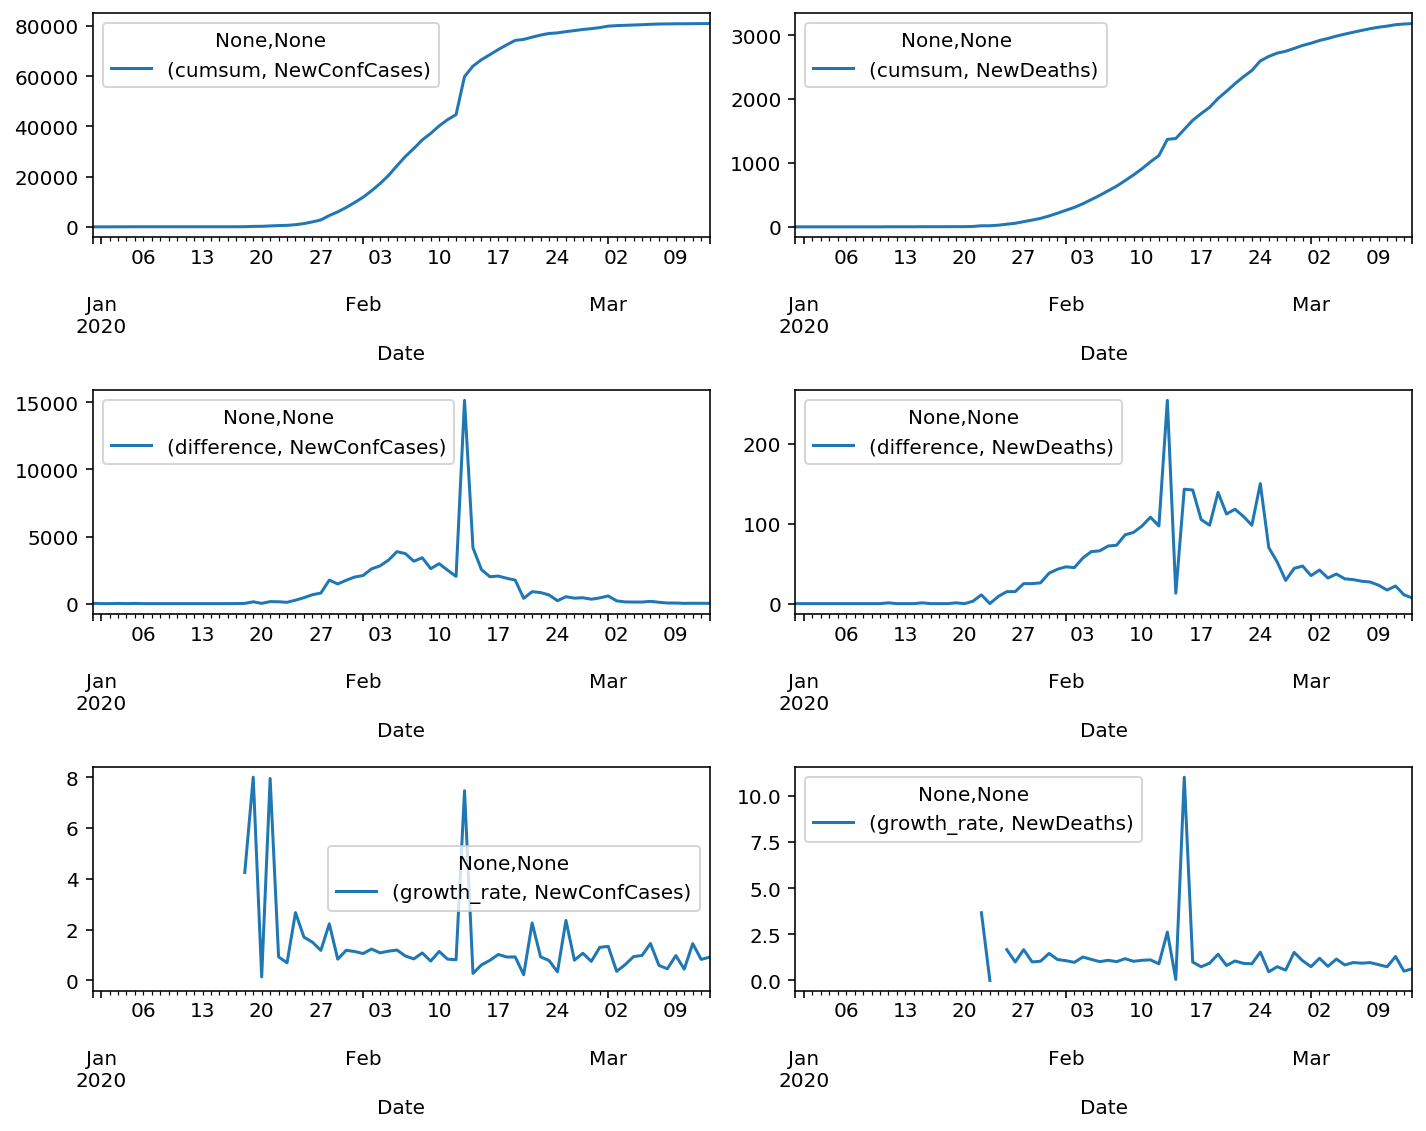

2020-01-15
Japan


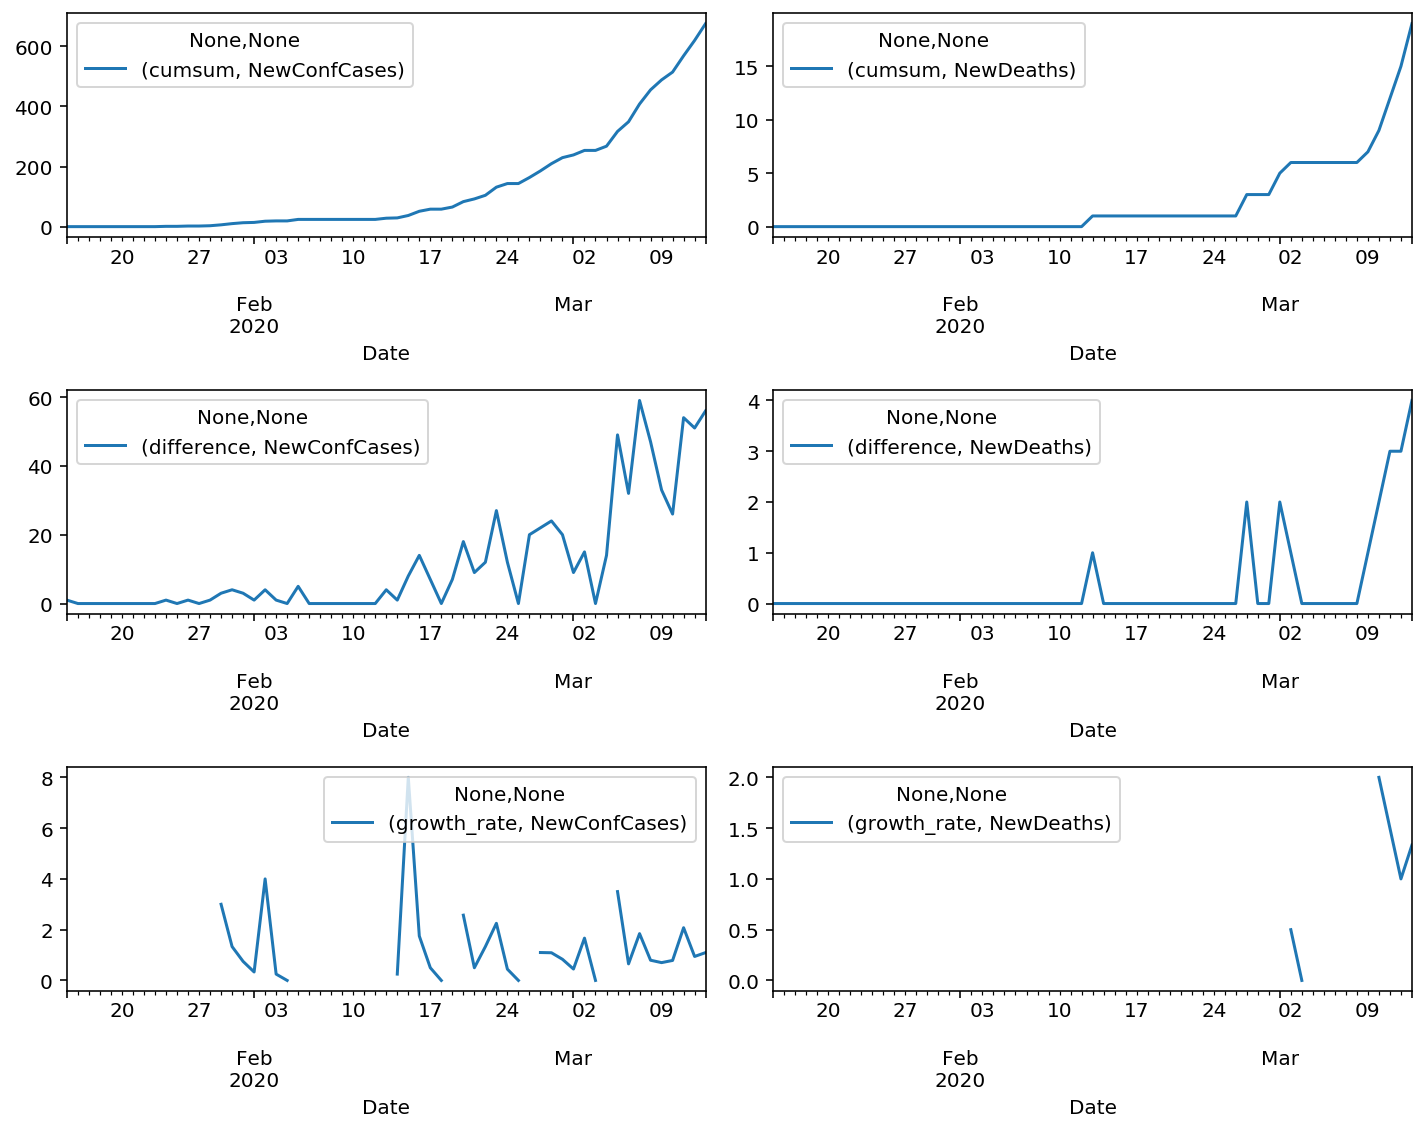

2020-01-20
South Korea


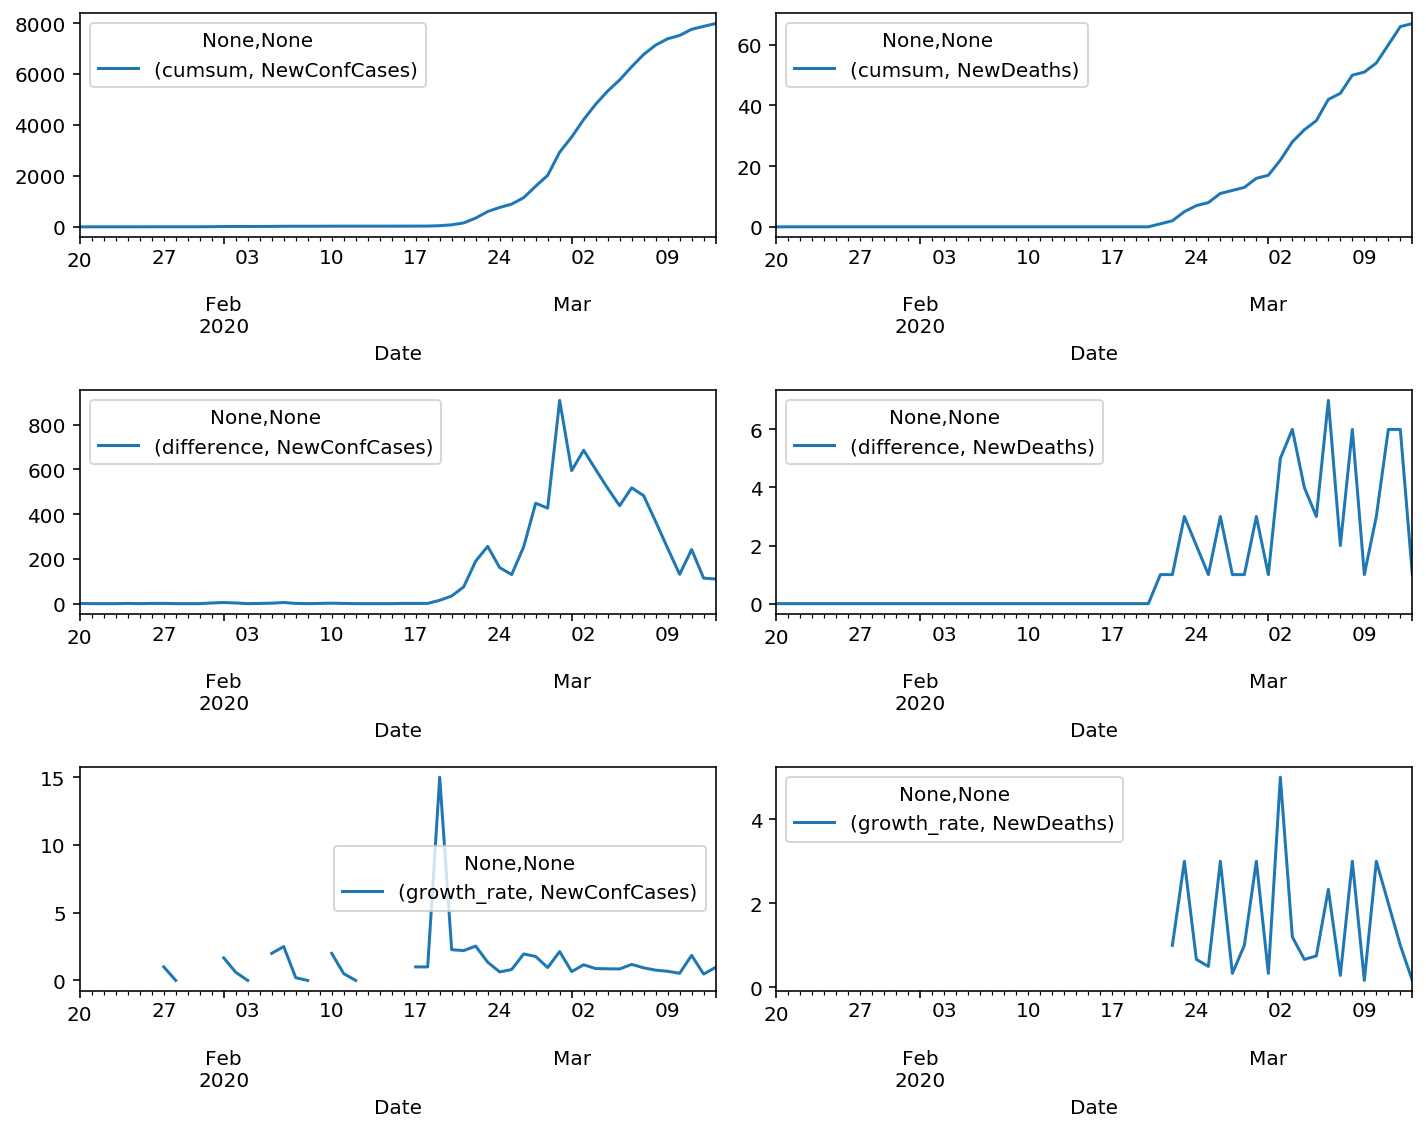

2020-02-20
Iran


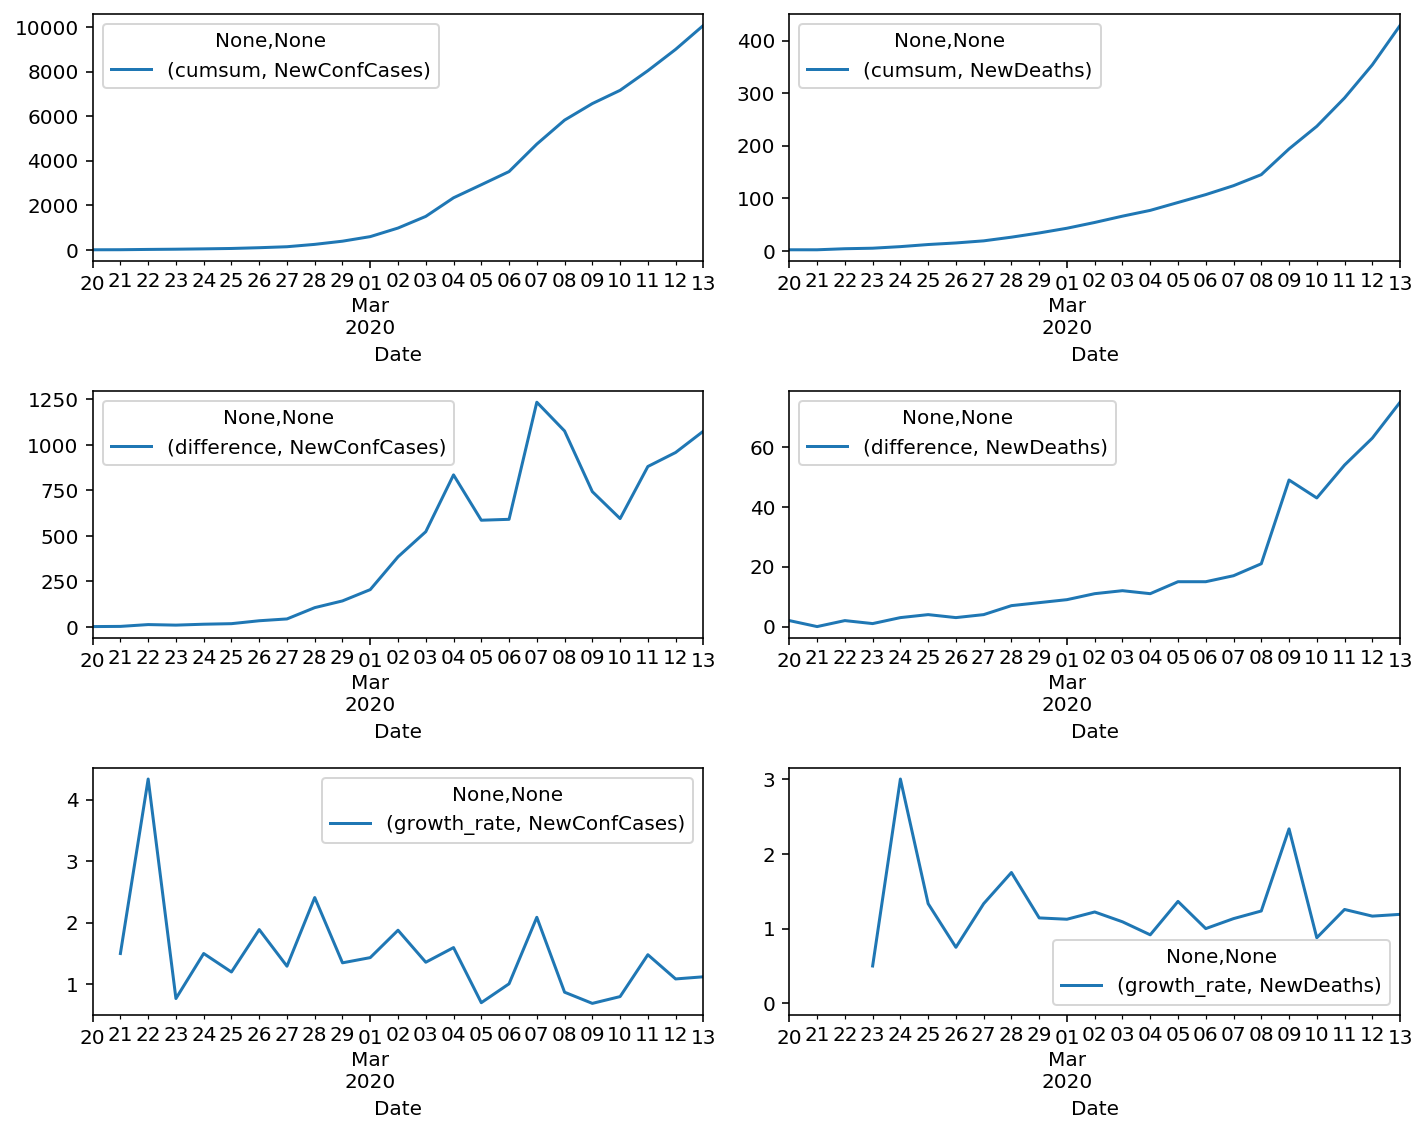

In [24]:
countries = ['Switzerland', 'Italy', 'China', 'Japan', 'South Korea', 'Iran']
for country in countries:
    first_date = plot_country(country=country)
    print(f"{country}")
    plt.show()

In [25]:
df.loc[idx[:,dt.date.today()],idx['growth_rate', 'NewConfCases']].sort_values(ascending=False).head(20)

CountryExp              Date      
Egypt                   2020-03-13    20.000000
Albania                 2020-03-13    12.000000
Bosnia and Herzegovina  2020-03-13     8.000000
Bulgaria                2020-03-13     5.333333
Finland                 2020-03-13     5.052632
Greece                  2020-03-13     3.777778
Slovakia                2020-03-13     3.666667
Estonia                 2020-03-13     3.666667
Canada                  2020-03-13     3.500000
Ireland                 2020-03-13     3.375000
Hungary                 2020-03-13     3.000000
Latvia                  2020-03-13     3.000000
Tunisia                 2020-03-13     3.000000
Croatia                 2020-03-13     3.000000
Belarus                 2020-03-13     3.000000
Germany                 2020-03-13     2.959410
Kuwait                  2020-03-13     2.666667
Australia               2020-03-13     2.142857
Iceland                 2020-03-13     2.133333
Moldova                 2020-03-13     2.000000
Name:

In [26]:
last_av_date = df.index.levels[1][-1]

In [27]:
last_date_df = df.swaplevel(axis=0).sort_index().loc[last_av_date]

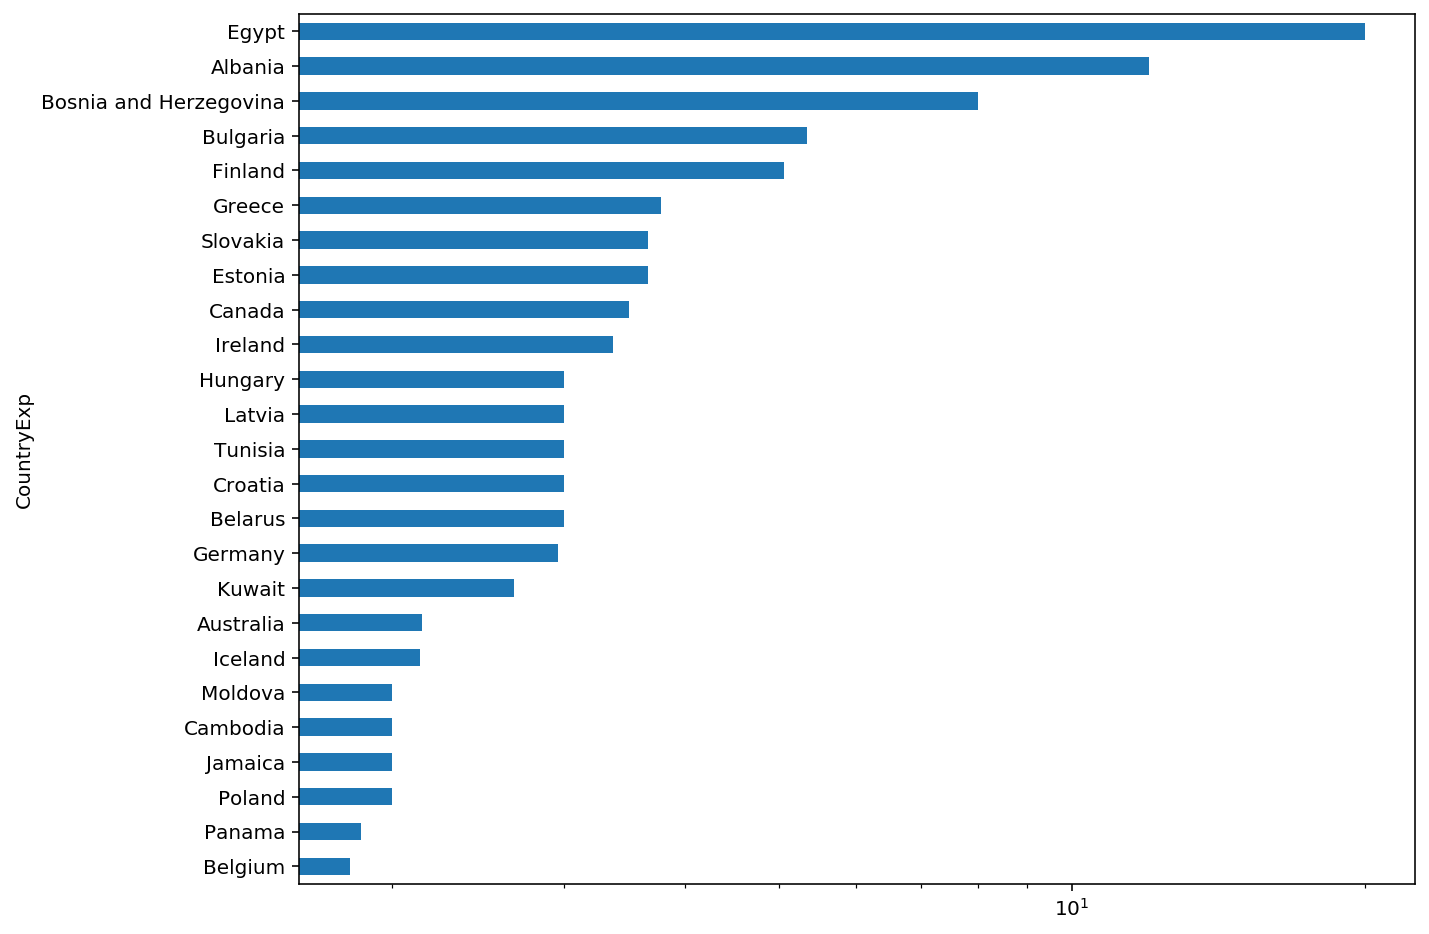

In [28]:
last_date_df['growth_rate', 'NewConfCases'].sort_values(ascending=False).head(25).plot(kind='barh', figsize=(10,8), logx=True).invert_yaxis()

In [29]:
hi_growth = list(last_date_df['growth_rate', 'NewConfCases'].sort_values(ascending=False).head(5).index)

2020-02-15
Egypt


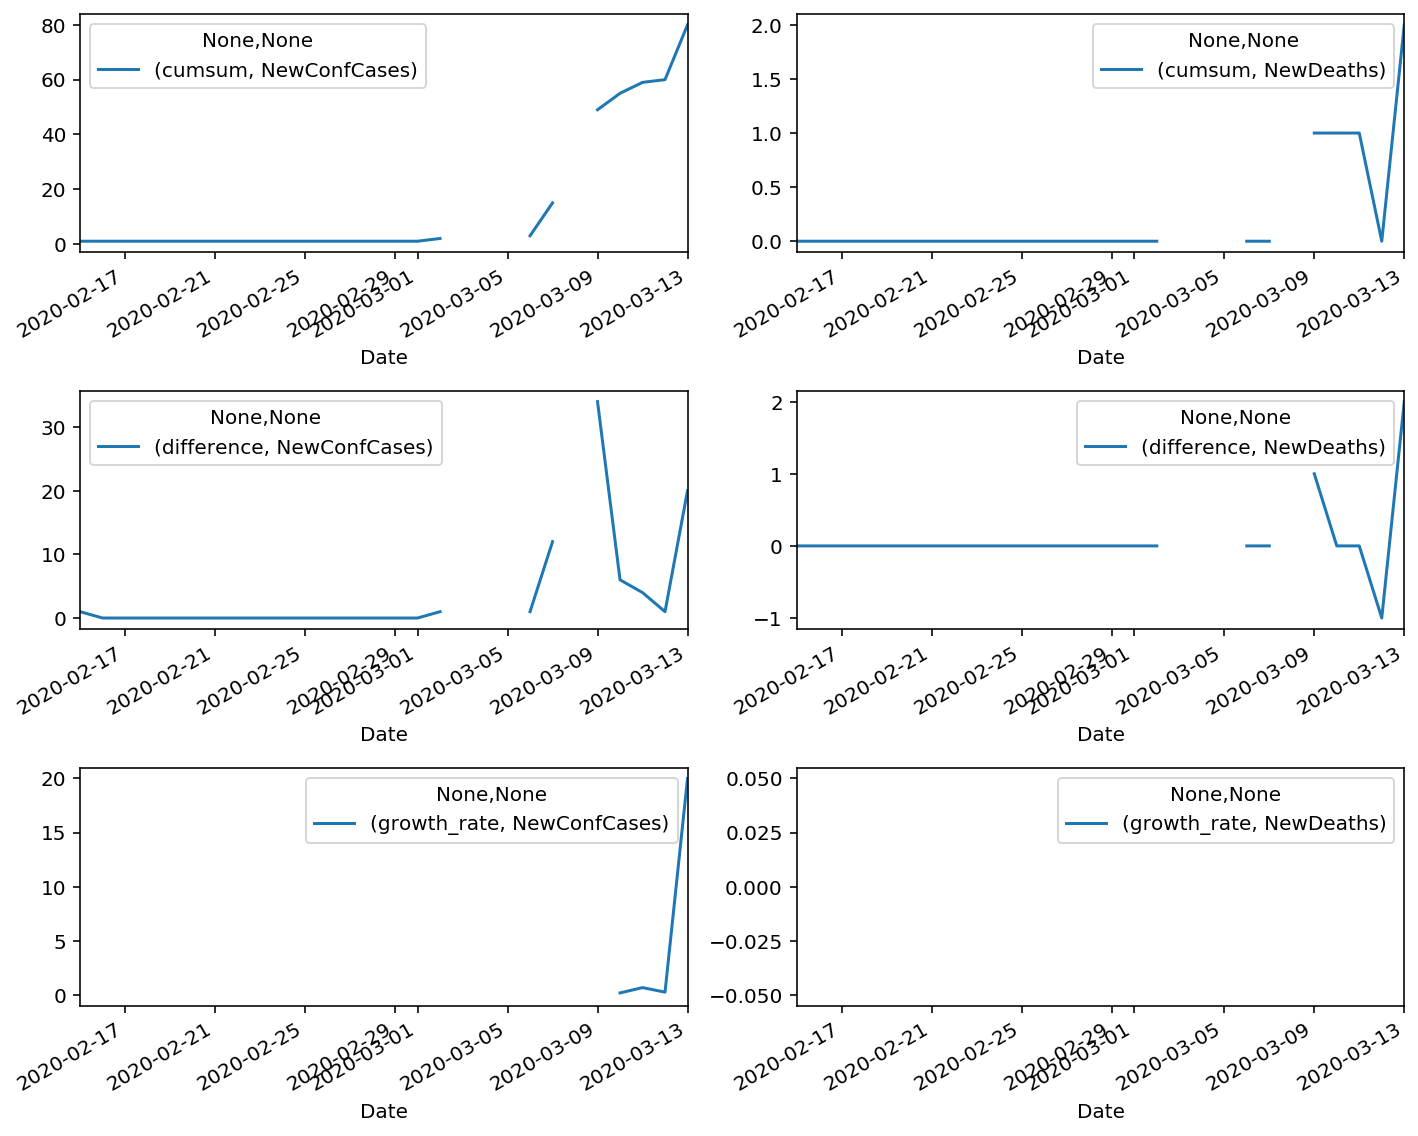

2020-03-09
Albania


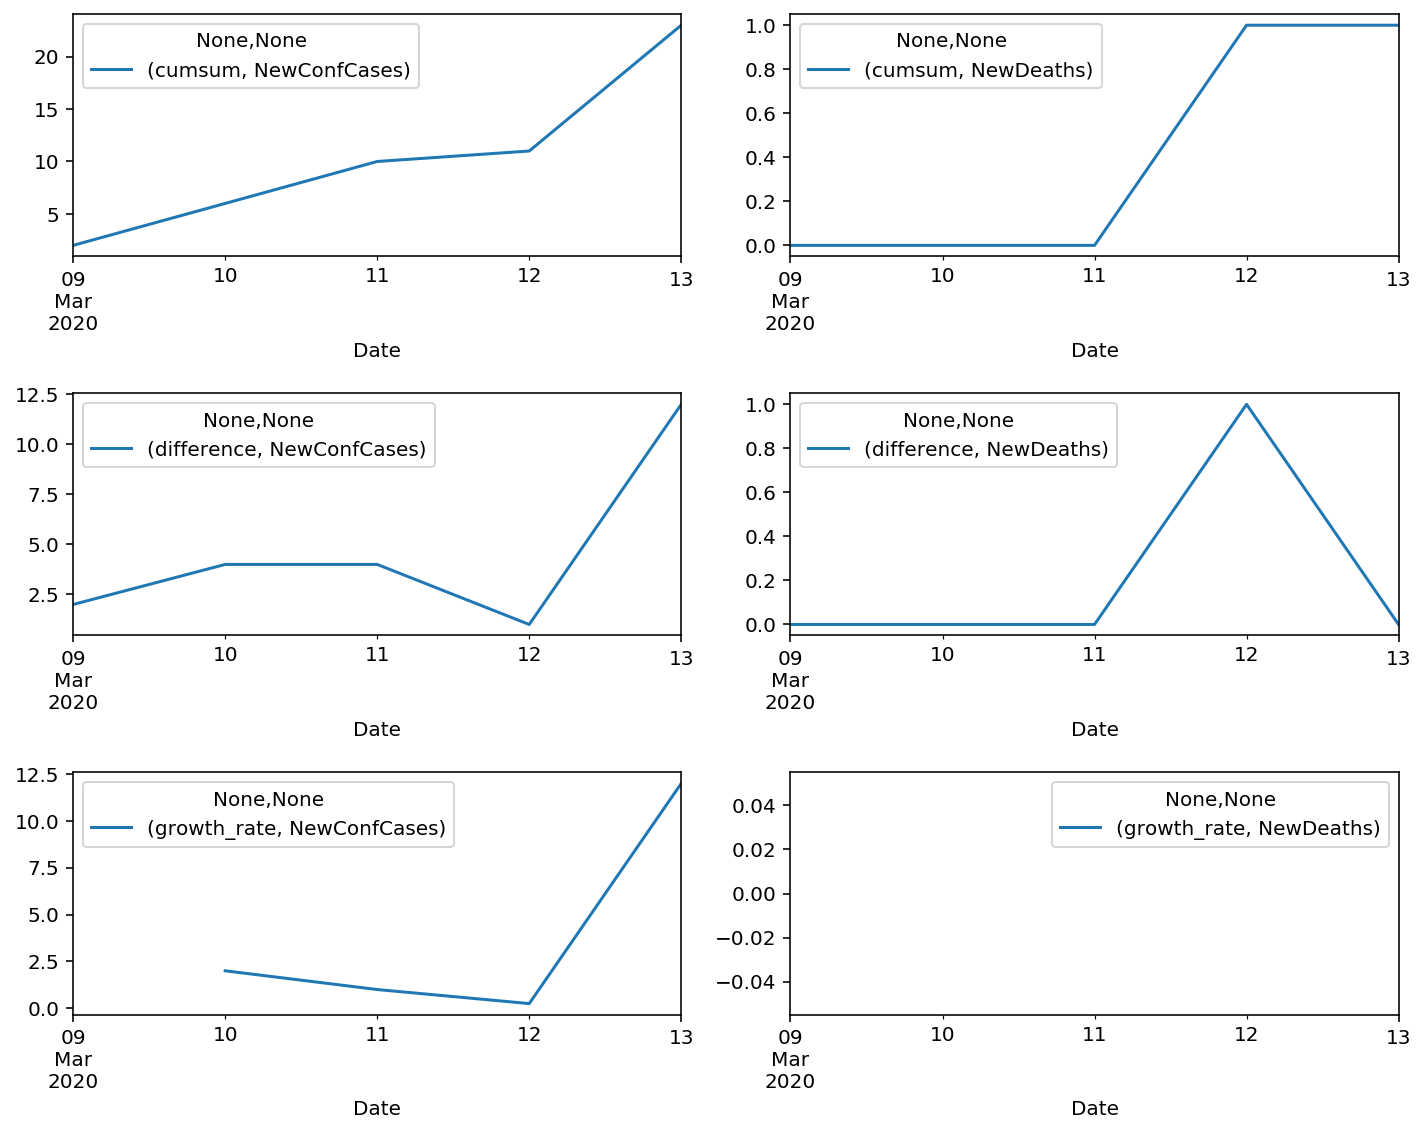

2020-03-06
Bosnia and Herzegovina


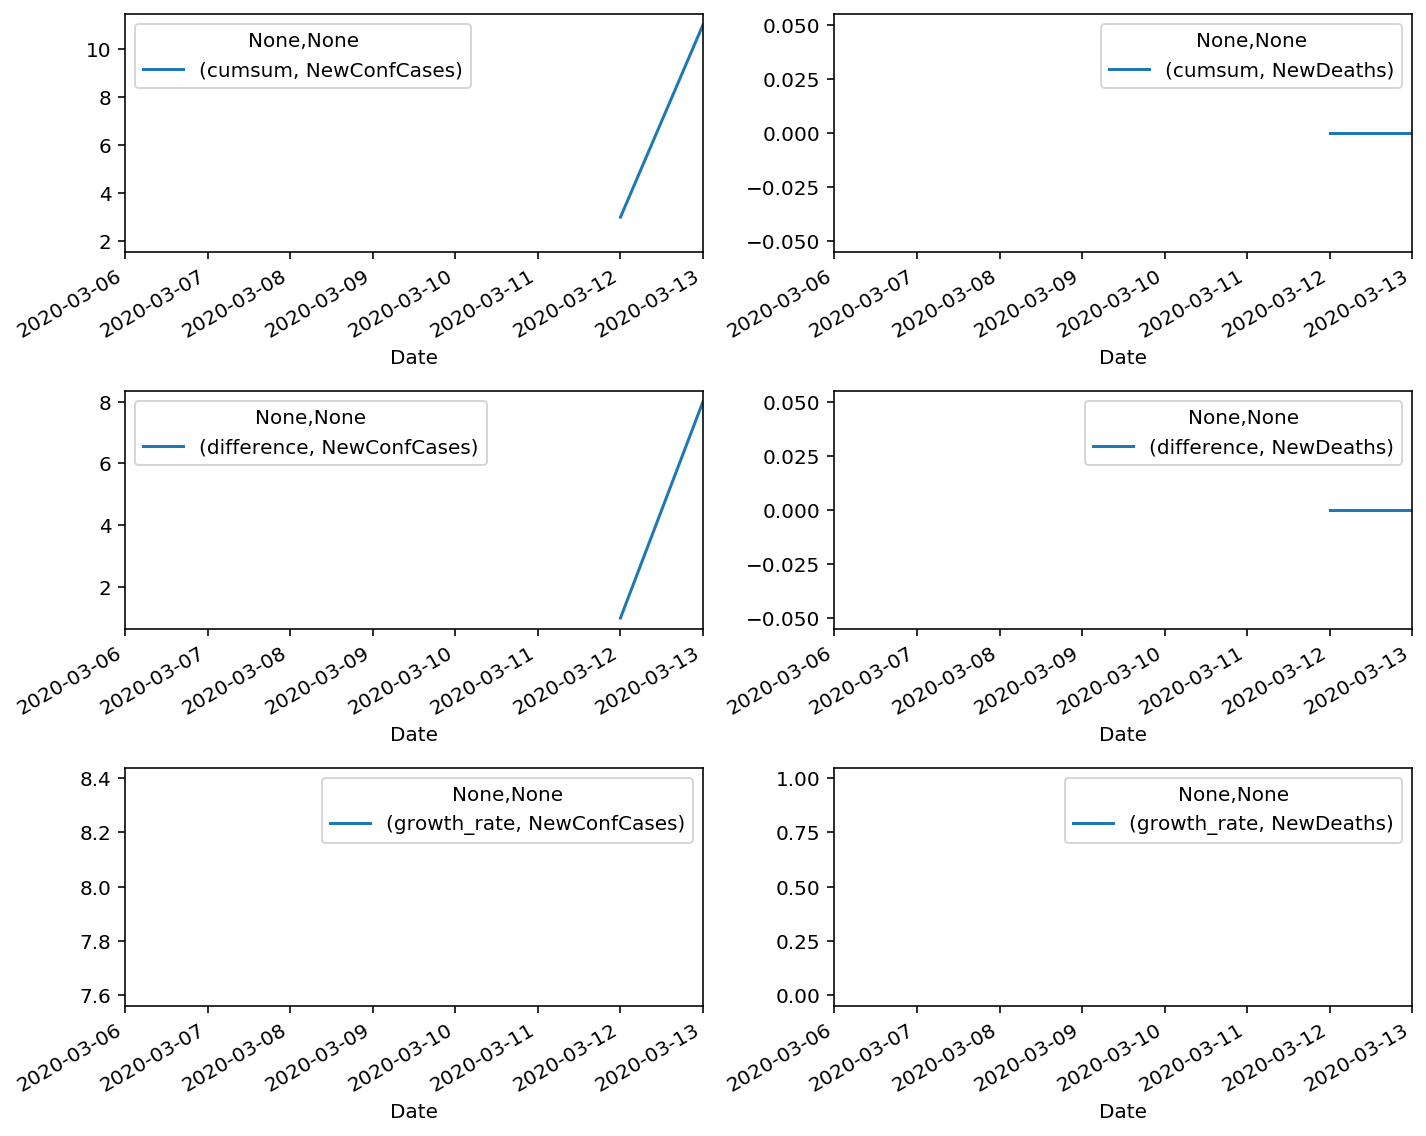

2020-03-08
Bulgaria


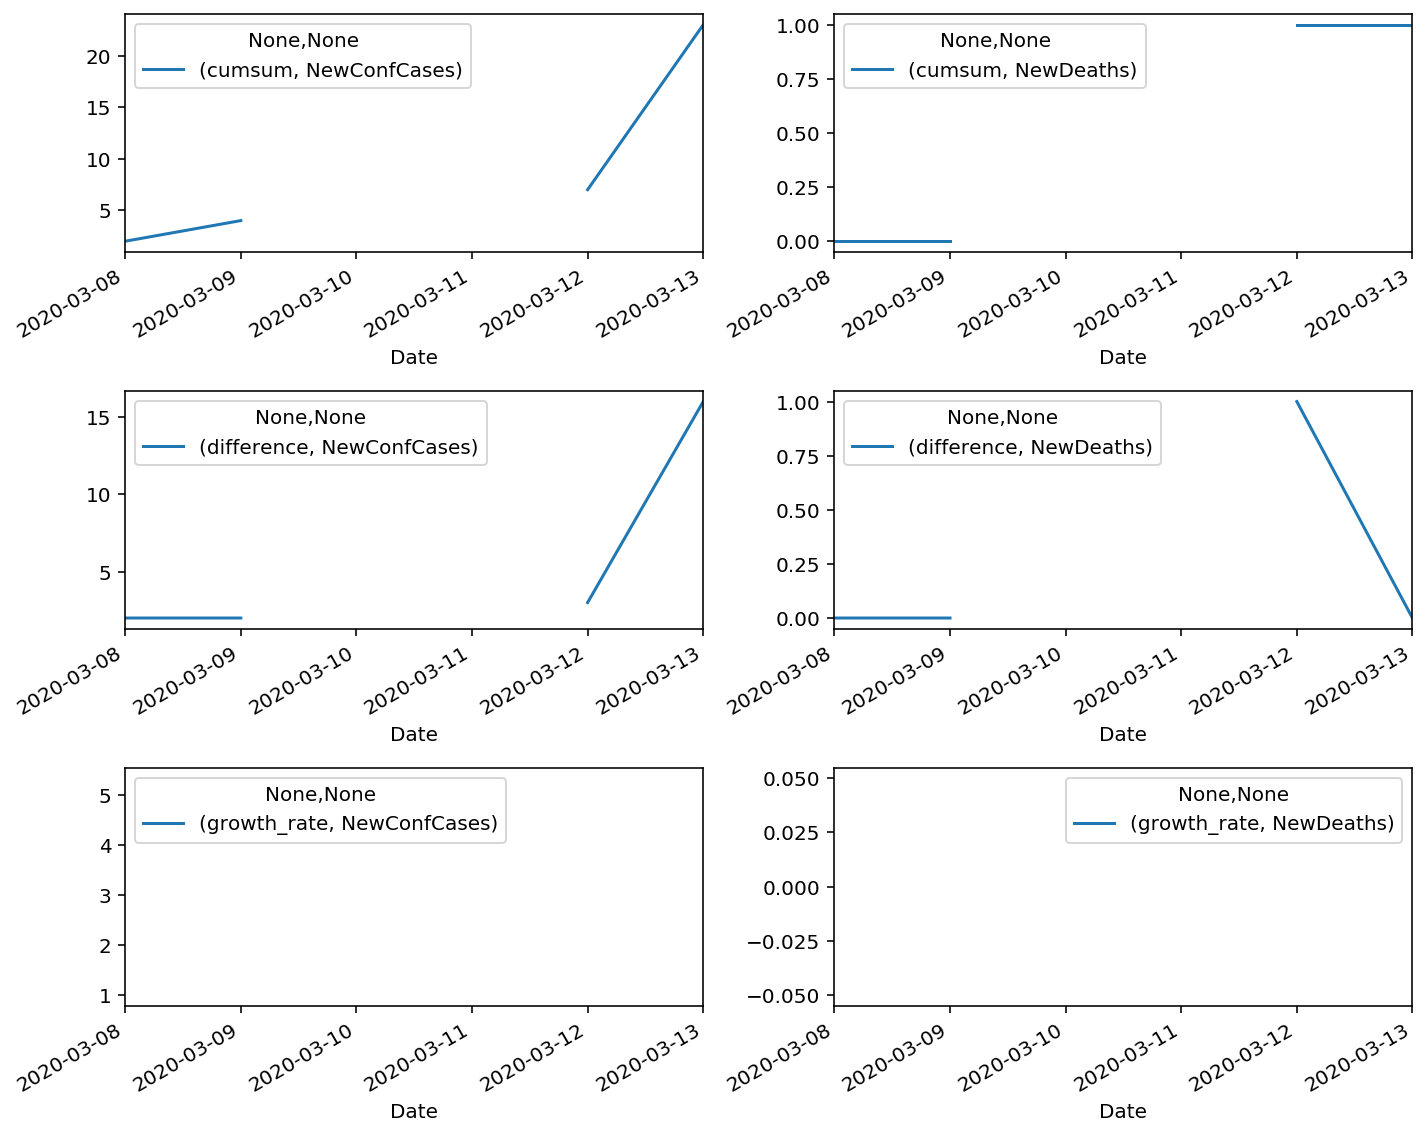

2020-01-30
Finland


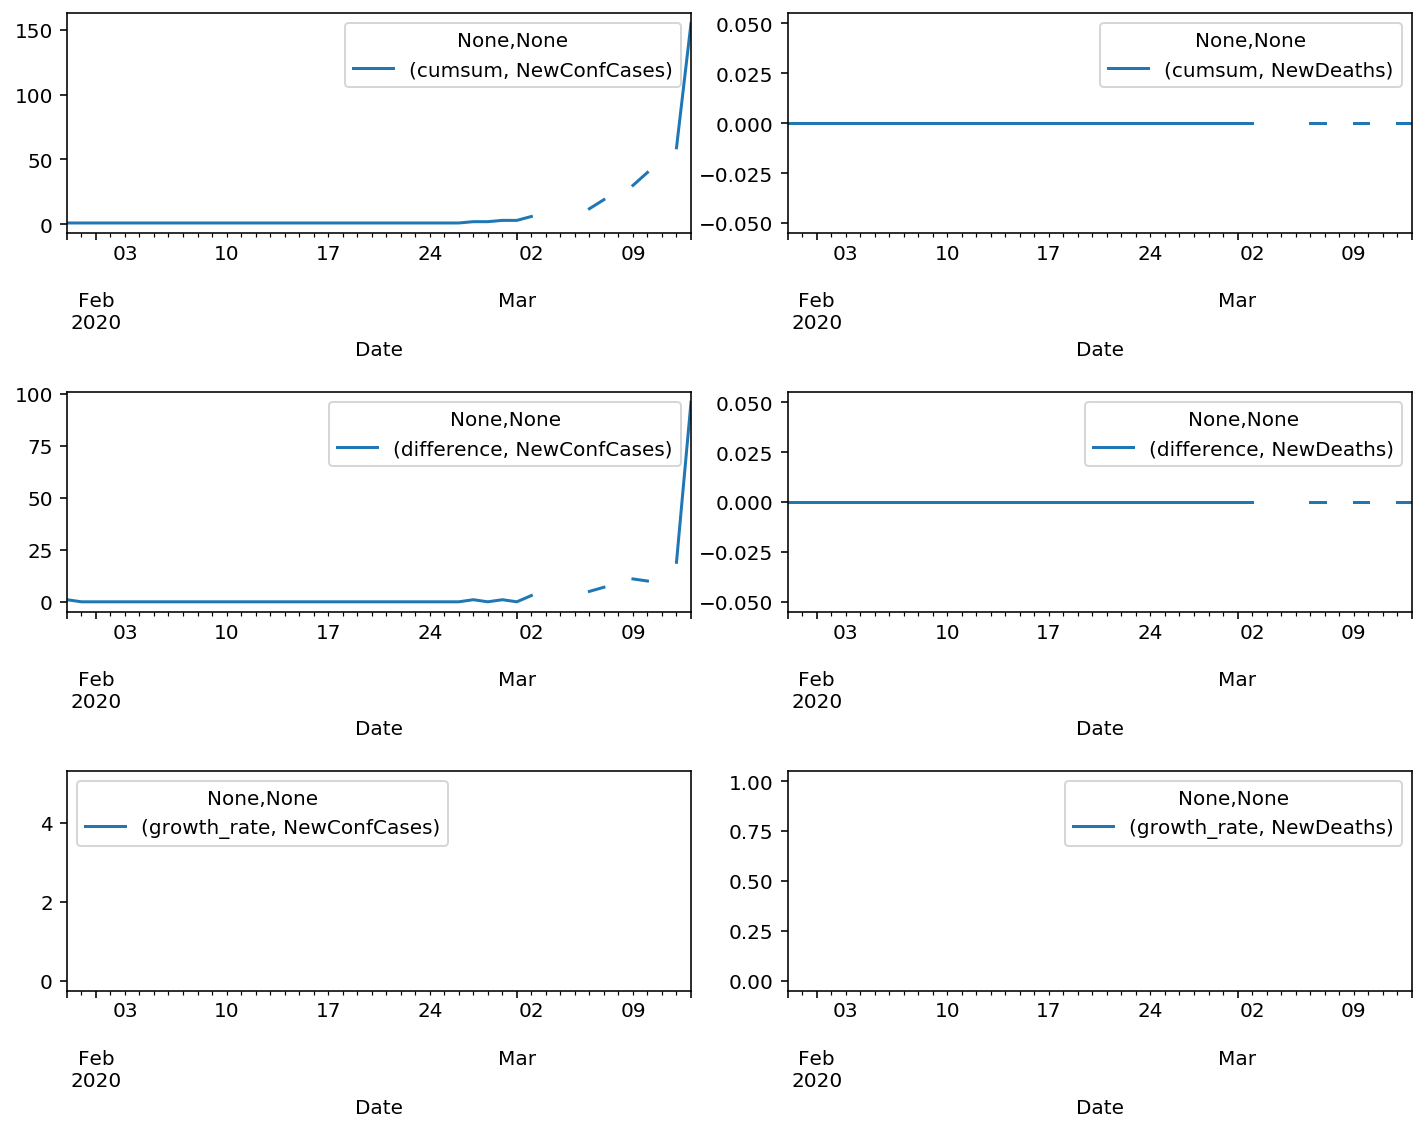

2020-02-27
Greece


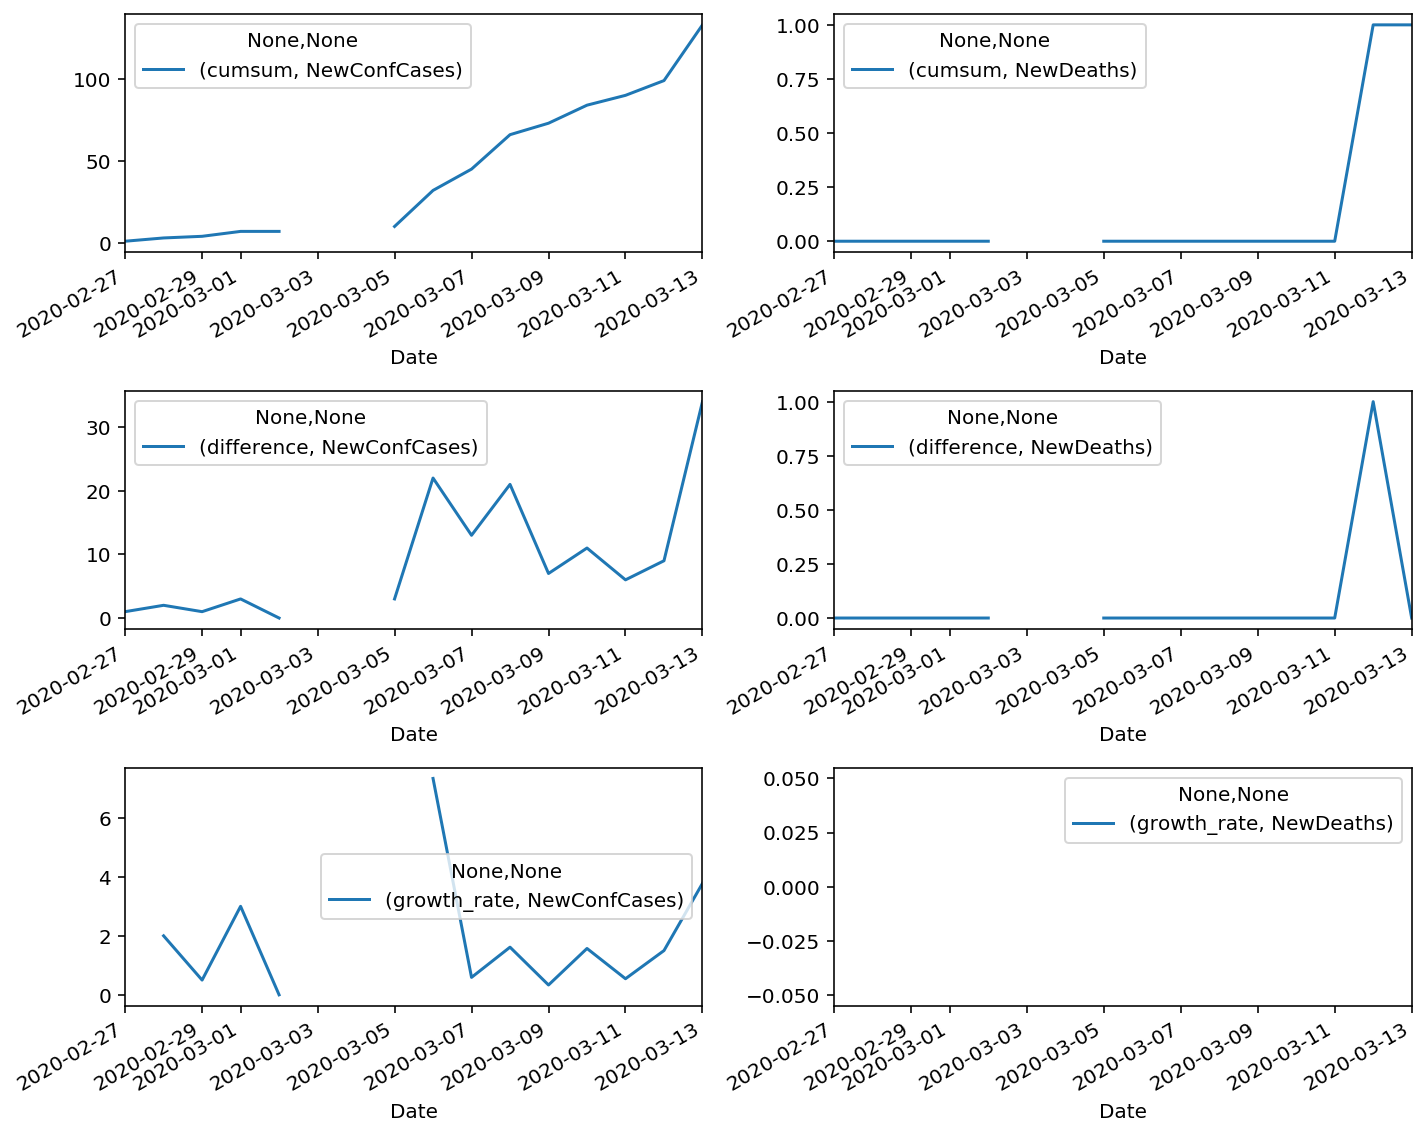

2020-03-07
Slovakia


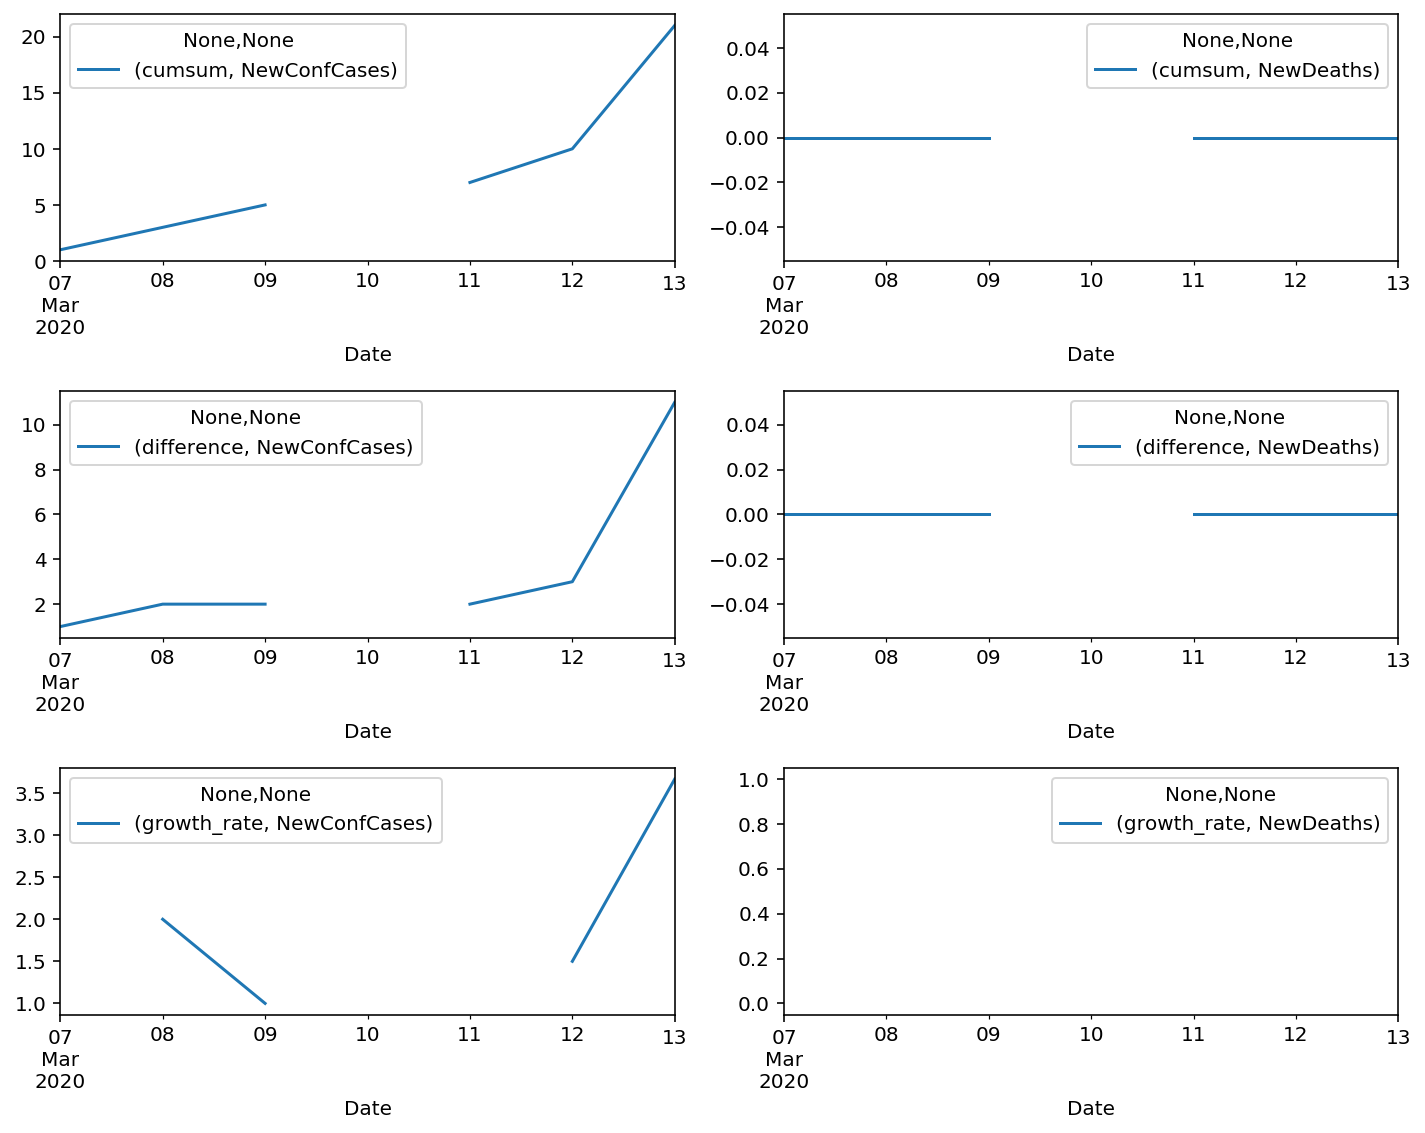

2020-02-28
Estonia


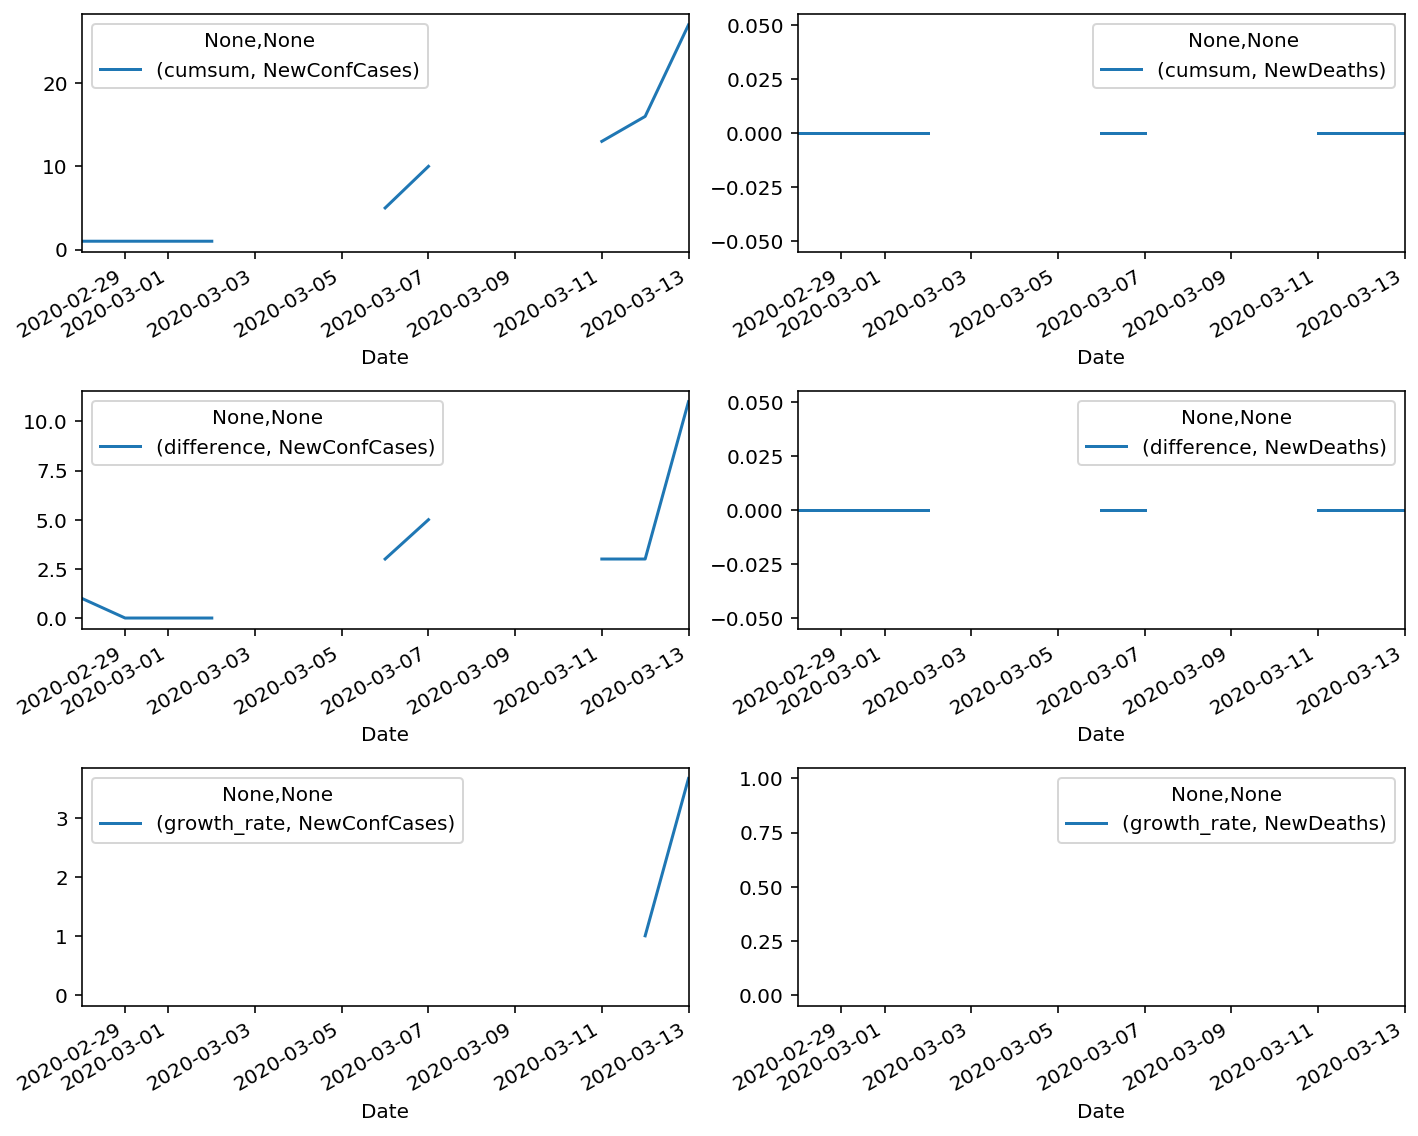

2020-01-26
Canada


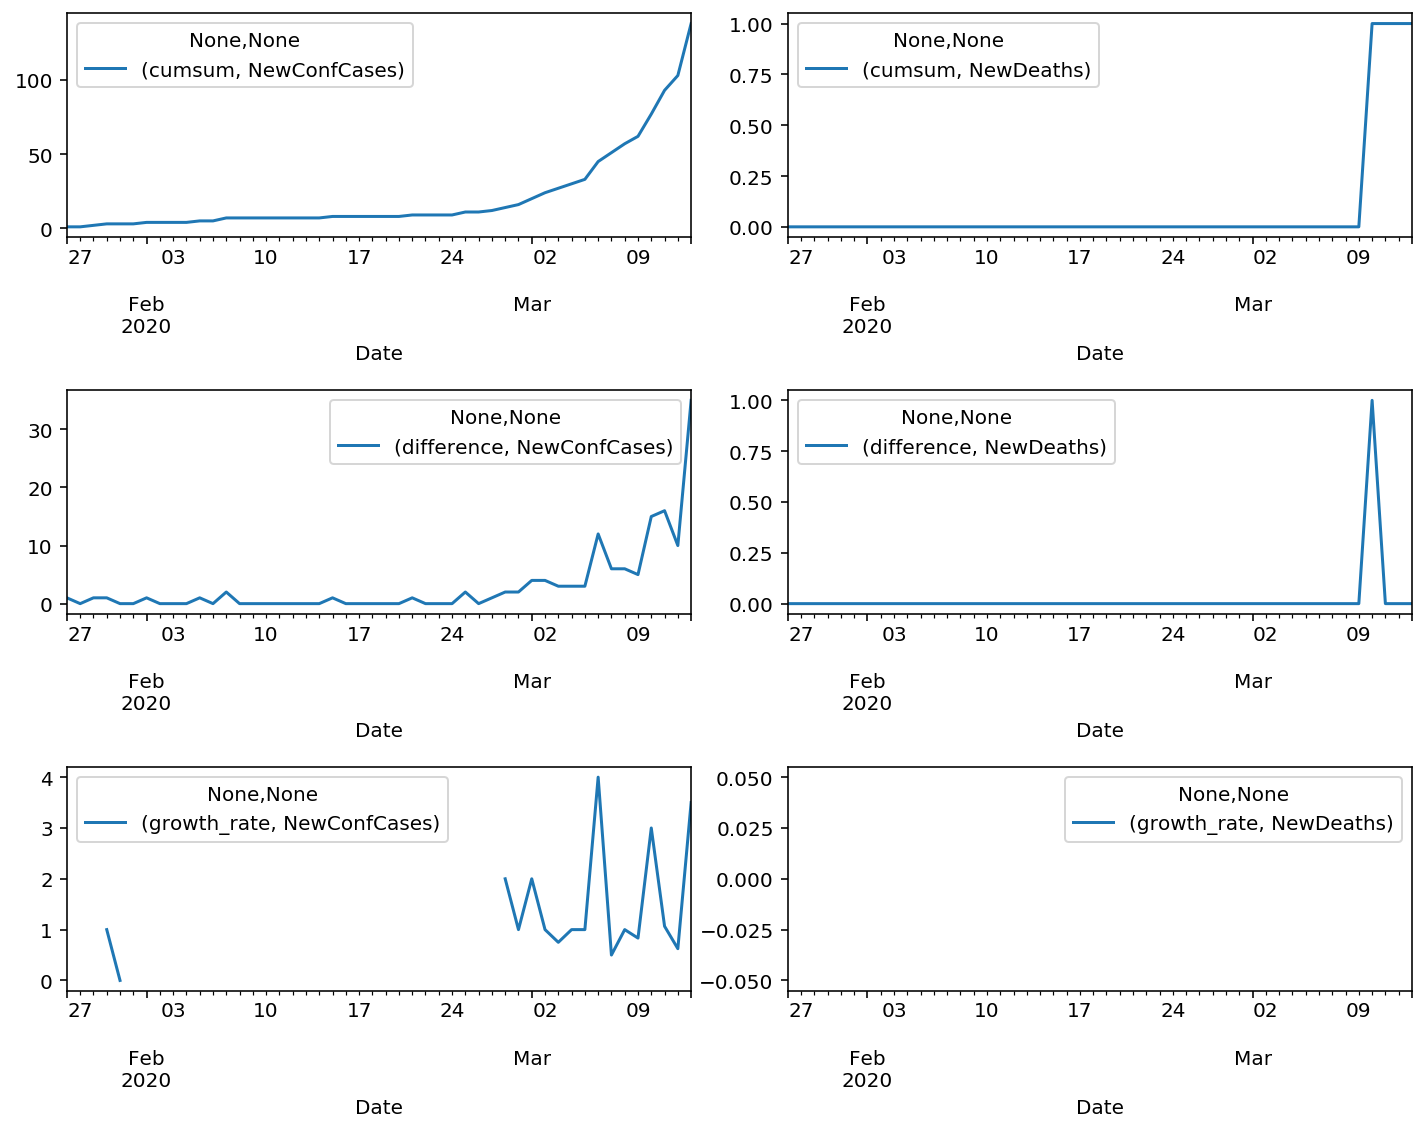

2020-03-01
Ireland


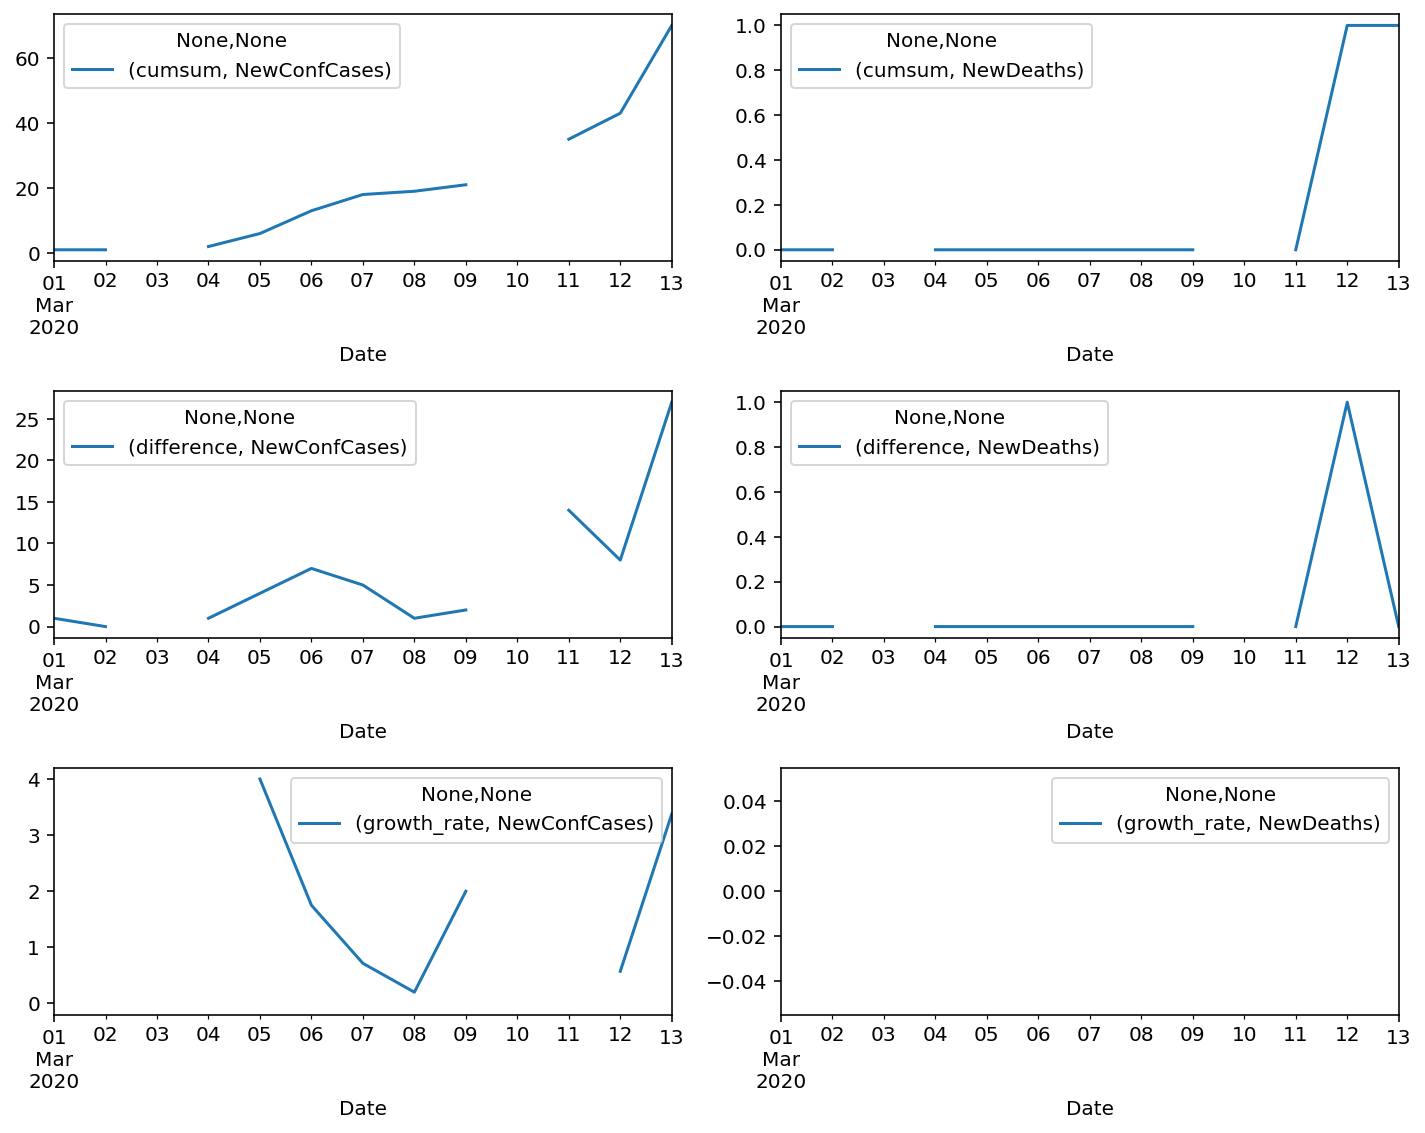

In [30]:
countries = hi_growth
for country in countries:
    first_date = plot_country(country=country)
    print(f"{country}")
    plt.show()

## start point

In [31]:
date_first_case = (ch_df.sum(axis=1)!=0).idxmax()

In [32]:
days = ch_df.loc[date_first_case:,'cumsum'].size

In [33]:
ch_cumsum_df = ch_df.loc[date_first_case:,'cumsum']

In [34]:
ch_cumsum_df['day'] = np.arange(1,days+1,1)

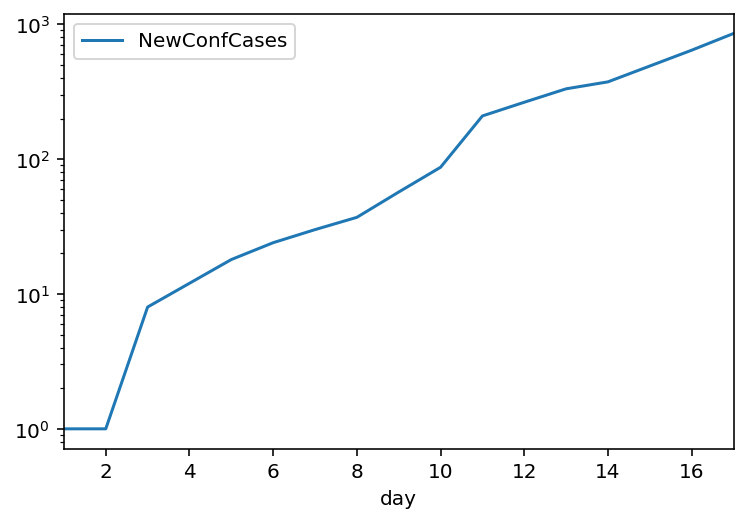

In [35]:
ch_cumsum_df.reset_index().set_index(['day'])[['NewConfCases']].plot(logy=True)

In [53]:
def plot_country_dayone(df=df, countries=['Switzerland', 'Italy', 'Germany', 'South Korea', 'China', 'Poland'], legend=True, lw=4):
    
    fig, ax = plt.subplots(figsize=(8,7))
    
    for country in countries:
    
        c_df = df.loc[country, idx[:,'NewConfCases']]
        date_first_case = (c_df.sum(axis=1)!=0).idxmax()
        days = c_df.loc[date_first_case:,'cumsum'].size

        c_cumsum_df = c_df.loc[date_first_case:,'cumsum']
        c_cumsum_df['day'] = np.arange(1,days+1,1)

        c_cumsum_df.reset_index().set_index(['day'])[['NewConfCases']].rename({'NewConfCases':country},axis=1)\
                   .plot(ax=ax, logy=True, lw=lw, alpha=.8)

    plt.grid(True, which='minor')
    plt.ylabel('Cumulative Confirmed Cases')
    plt.title('Cumulative Confirmed Cases')
    if legend == False:
        ax.legend().set_visible(False)



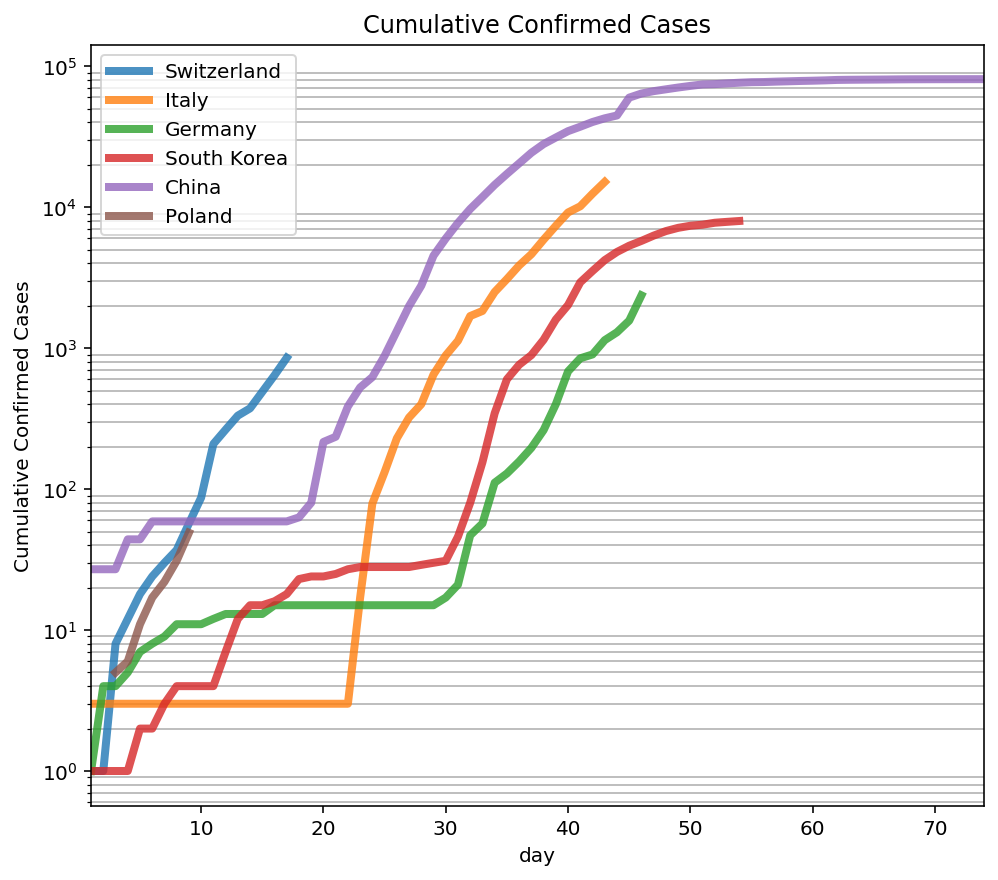

In [54]:
plot_country_dayone()

In [38]:
countries

['Egypt',
 'Albania',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Finland',
 'Greece',
 'Slovakia',
 'Estonia',
 'Canada',
 'Ireland']

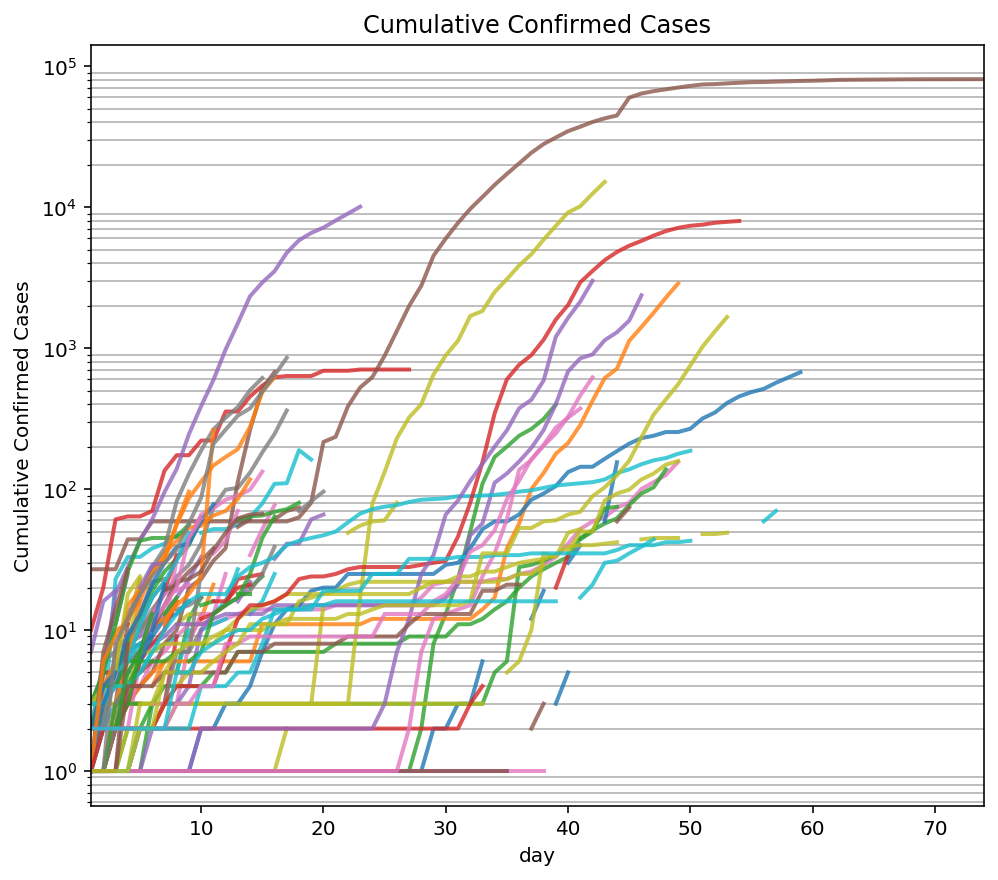

In [44]:
plot_country_dayone(countries=countries_lst, legend=False, lw=2)

# Tempo di raddoppiamento

# Rapportato alla popolazione

In [56]:
pop_df = pd.read_csv('./_input/02_world_population/API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv')

ParserError: Error tokenizing data. C error: Expected 3 fields in line 5, saw 65


In [52]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 6 columns):
Country Code    263 non-null object
Region          217 non-null object
IncomeGroup     217 non-null object
SpecialNotes    93 non-null object
TableName       263 non-null object
Unnamed: 5      0 non-null float64
dtypes: float64(1), object(5)
memory usage: 12.5+ KB
